# Pathfinding Exploration

- DFS
- BFS
- IDDFS (removed completely)
- A-star

In [57]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

from utils.search import bfs, dfs, dfs_heuristic, greedy_bfs, a_star
from utils.graph import Graph
from utils.plots import plot_grid, plot_path

## A simple example of N = 1

Also showing the different types of grids that can be used.

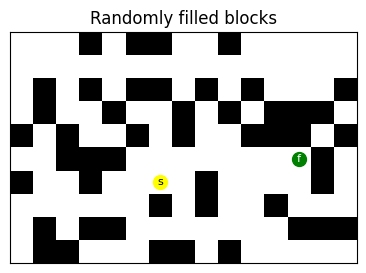

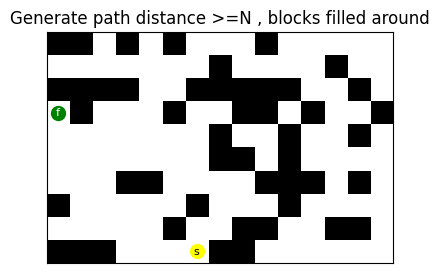

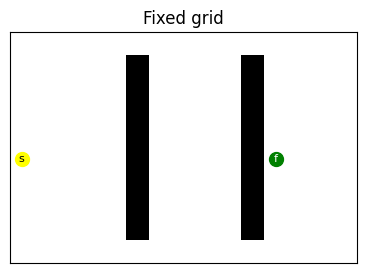

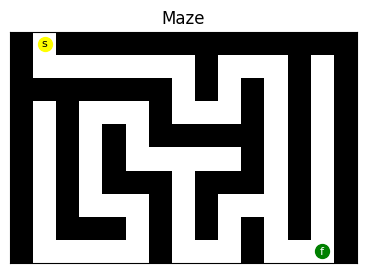

In [2]:
percent_blockage = 0.4

graph = Graph(rows=10, cols=15)


graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Randomly filled blocks")
plt.show()

graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Generate path distance >=N , blocks filled around")
plt.show()

graph.generate_grid(grid_type="fixed", variant=2)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Fixed grid")
plt.show()

graph.generate_grid(grid_type="maze")
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Maze")
plt.show()

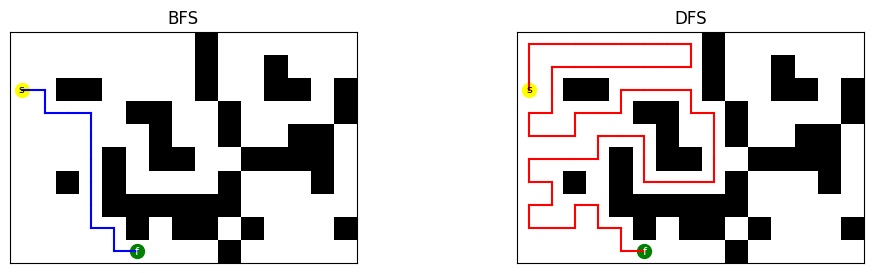

BFS:
Time: 0.0001900196075439453 (s)
# Iteractions: 64
Path length: 12

DFS:
Time: 0.0001380443572998047 (s)
# Iteractions: 73
Path length: 58


In [3]:
graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)

bfs_path, bfs_complexity = graph.search(bfs)
dfs_path, dfs_complexity = graph.search(dfs)

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], dfs_path, c='red',label='DFS')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

### Let's see this interactively

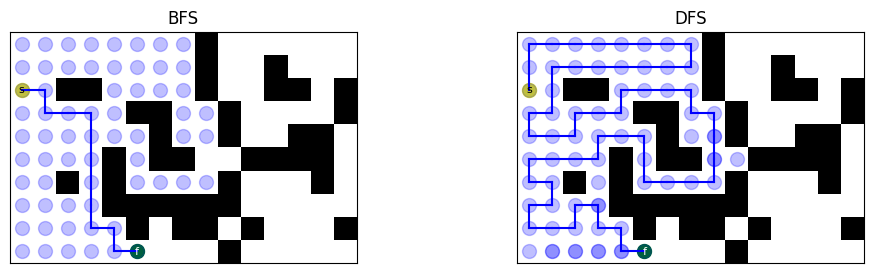

In [4]:
bfs_generator = graph.search_generator(bfs)
dfs_generator = graph.search_generator(dfs)

generators = [bfs_generator, dfs_generator]

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("DFS")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

## Let's do this many times and compare.

Important to note that as the `percent_blockage` gets to a certain point, there tends to become less and less available paths (and neighbors), so we see some convergence between methods. I'll stop it by a certain point, as we're guaranteeing an existing path, so going beyond a certain `percent_blockage` becomes redundant.

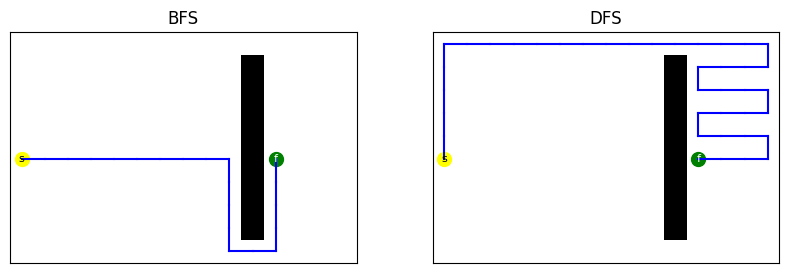

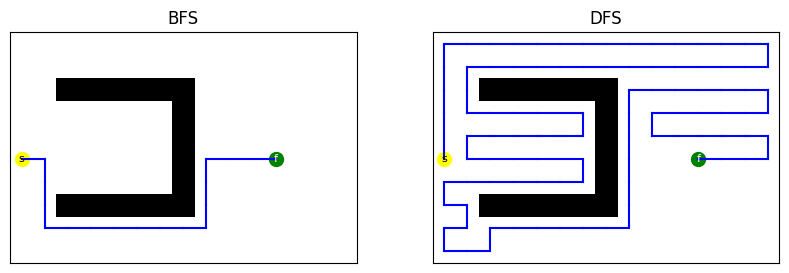

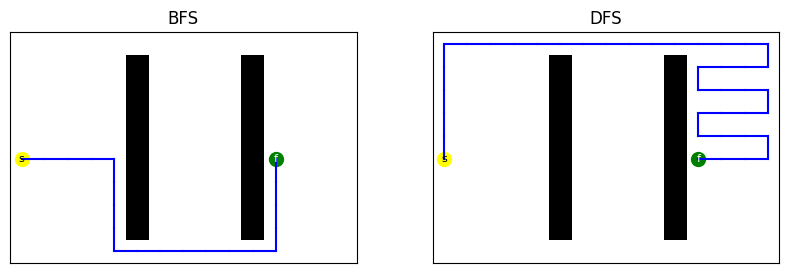

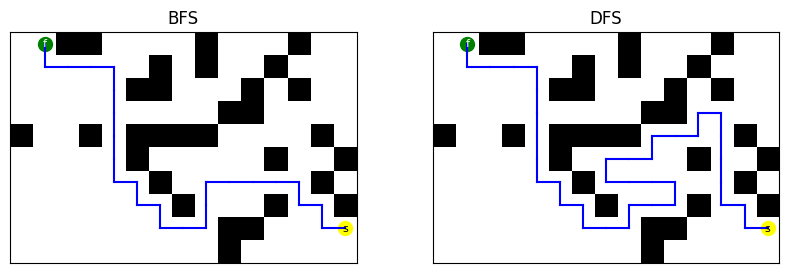

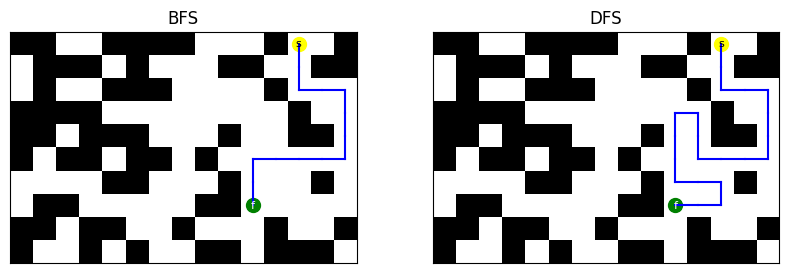

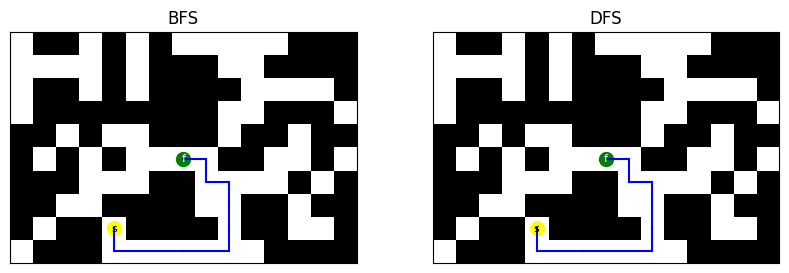

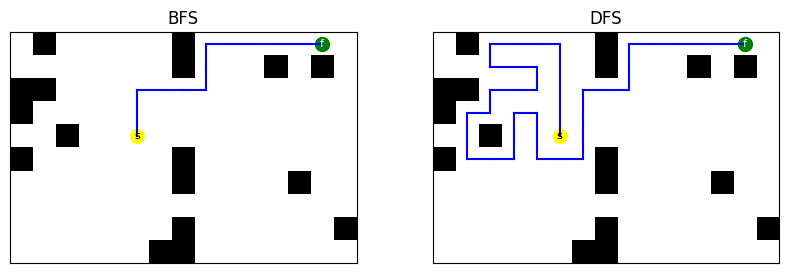

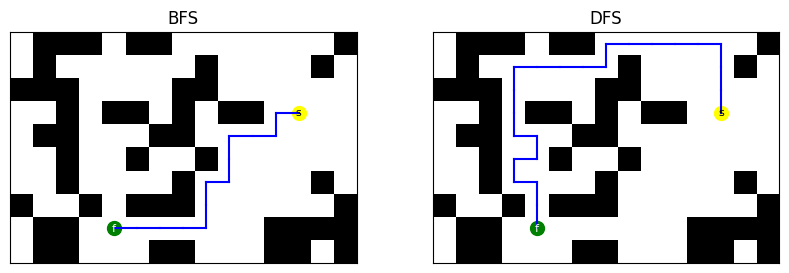

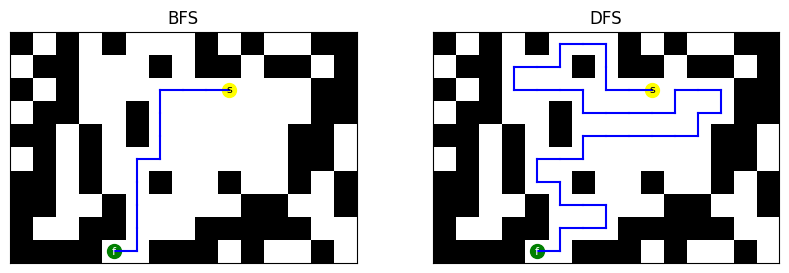

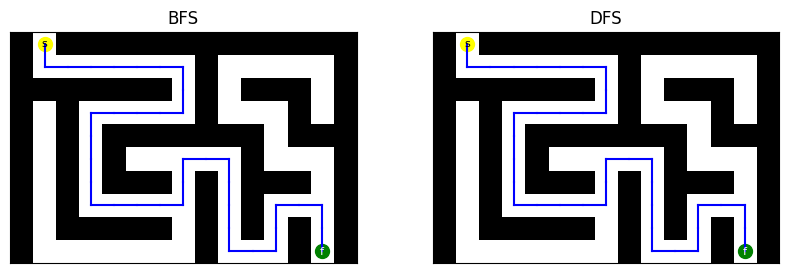

In [68]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [69]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [70]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time            iterations                 length  \
                      bfs       dfs         bfs         dfs        bfs   
percent type                                                             
0.0     fixed_0  0.000278  0.000064  123.000000   40.000000  19.000000   
        fixed_1  0.000222  0.000130  111.000000  102.000000  17.000000   
        fixed_2  0.000213  0.000055  115.000000   40.000000  19.000000   
0.2     random   0.000105  0.000083   61.242000   77.001000   9.449000   
0.4     random   0.000073  0.000066   42.912000   59.846000  13.444000   
0.6     random   0.000044  0.000032   25.217000   29.138000  14.480000   
0.2     random   0.000170  0.000088  100.705000   78.880000  12.272000   
0.4     random   0.000128  0.000076   75.868000   67.318000  12.754000   
0.6     random   0.000097  0.000056   55.909000   48.229000  13.487000   
0.0     maze     0.000082  0.000081   48.942122   71.292666  36.332053   

                             
                        dfs  
percent type                 
0.0     fixed_0   39.000000  
        fixed_1  101.000000  
        fixed_2   39.000000  
0.2     random    44.165000  
0.4     random    20.942000  
0.6     random    15.834000  
0.2     random    54.758000  
0.4     random    34.938000  
0.6     random    26.829000  
0.0     maze      36.332053

# Adding heuristics to search

Right now selecting a neighbor has equivalent "cost". We know where the starting + end locations are located, so can we use this information?

Rather than BFS / DFS randomly traversing the space, let's intro some heuristics.

Doing this will also introduce a new Data Structure `Priority Queue`. Rather than simply using a queue, we can sort it based on some priority given a heuristic.

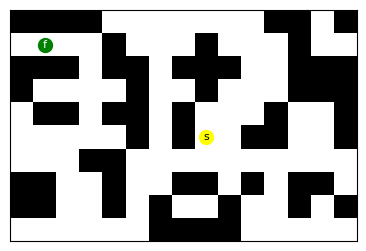

In [59]:
percent_blockage = 0.4
graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

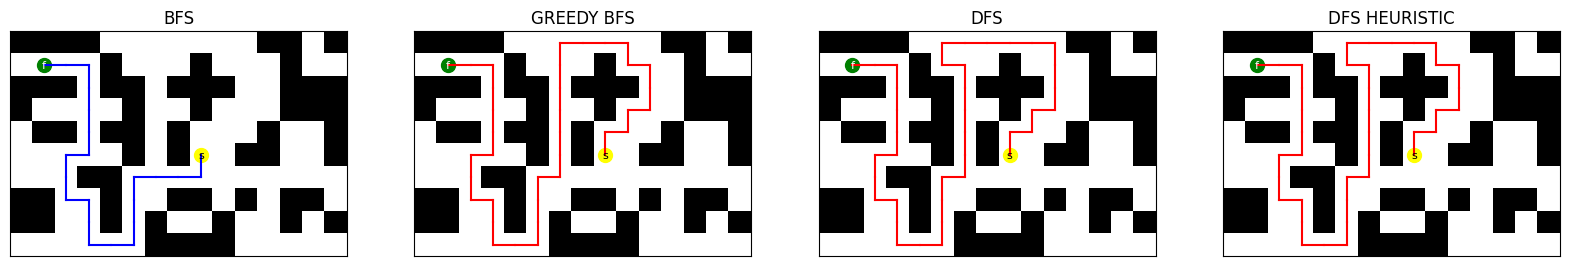

BFS:
Time: 0.000225067138671875 (s)
# Iteractions: 84
Path length: 21

GREEDY BFS:
Time: 0.0001659393310546875 (s)
# Iteractions: 54
Path length: 35

DFS:
Time: 0.00010704994201660156 (s)
# Iteractions: 56
Path length: 37

DFS HEURISTIC:
Time: 0.00014209747314453125 (s)
# Iteractions: 56
Path length: 37


In [60]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
dfs_path, dfs_complexity = graph.search(dfs)
dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], dfs_path, c='red',label='DFS')
plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

plt.show()


print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

print()
print("DFS HEURISTIC:")
print("Time:", dfs_heur_complexity["time"], "(s)")
print("# Iteractions:", dfs_heur_complexity["iterations"])
print("Path length:", dfs_heur_complexity["length"])

### Again, let's see this interactively to how the heuristic behaves

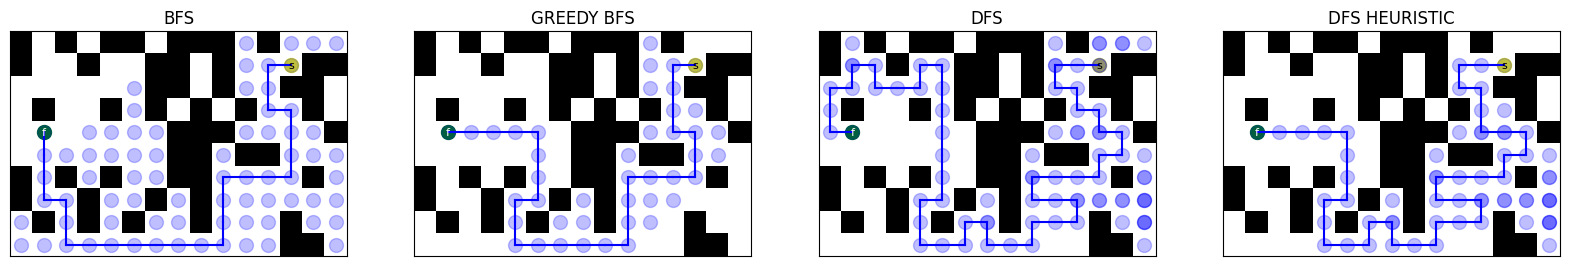

In [28]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)

generators = [bfs_generator, greedy_bfs_generator, dfs_generator, dfs_heur_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("DFS")
    axes[3].set_title("DFS HEURISTIC")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

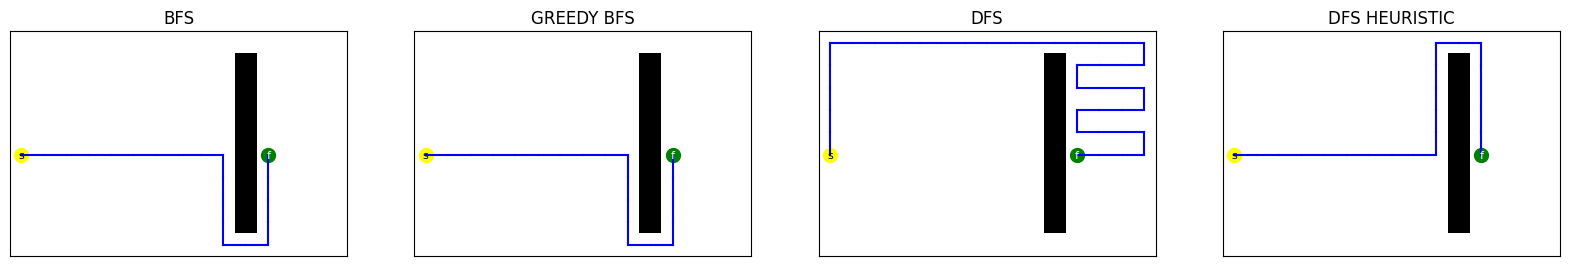

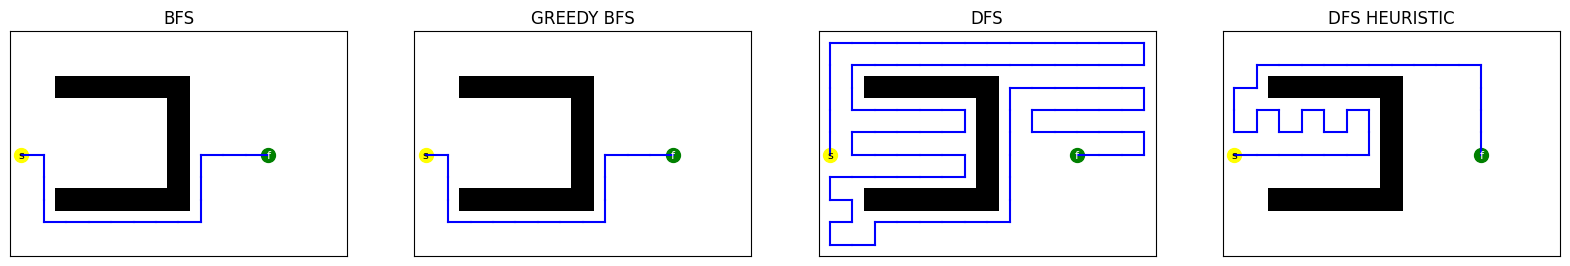

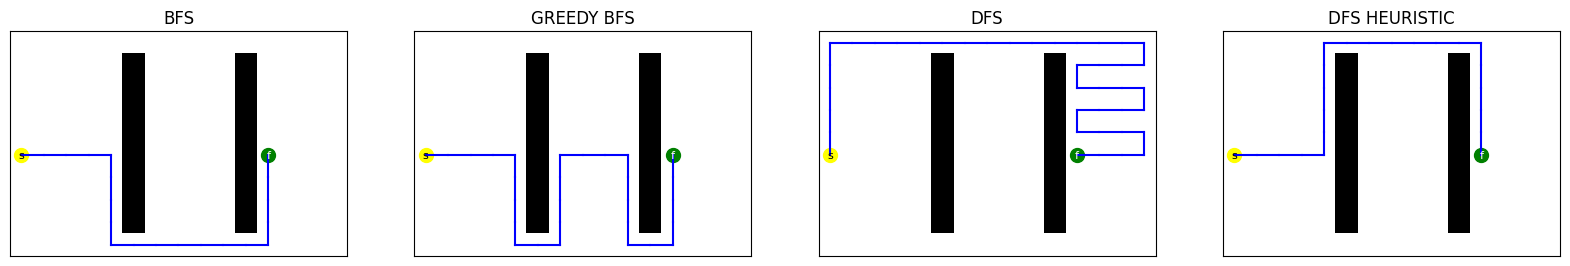

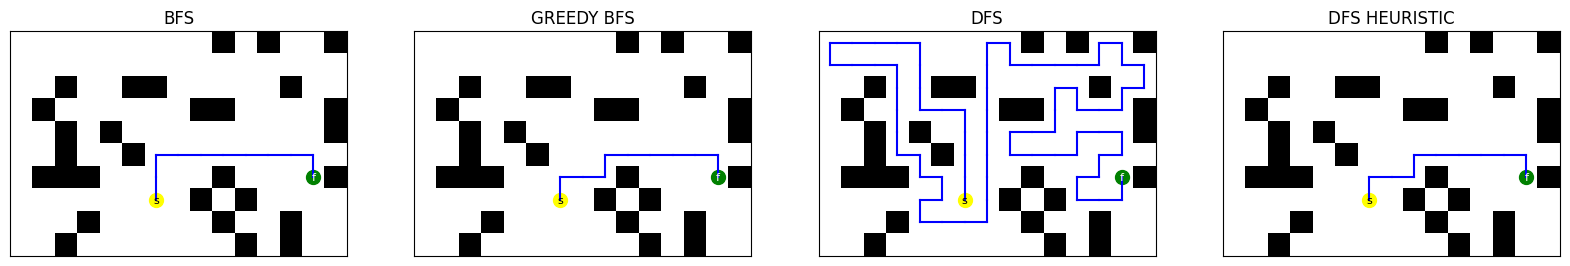

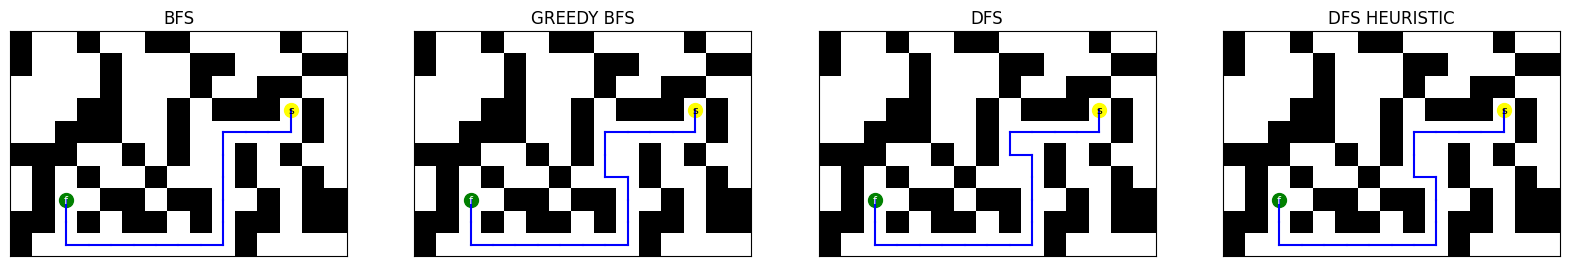

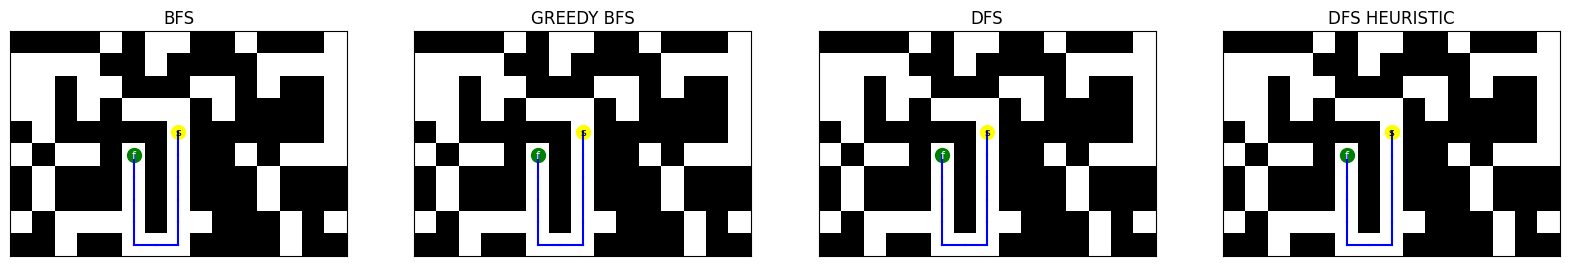

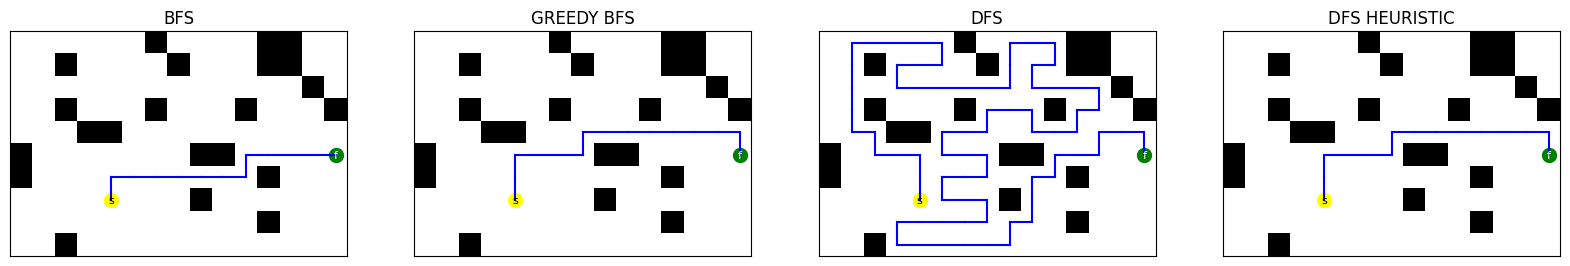

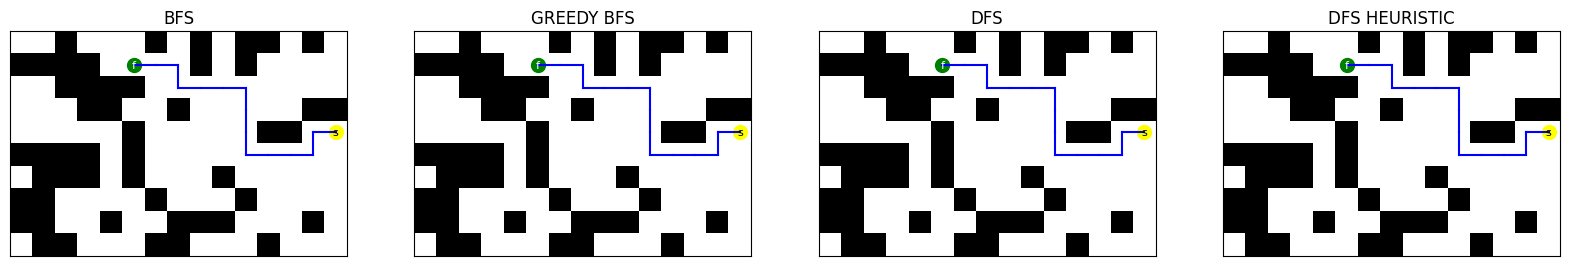

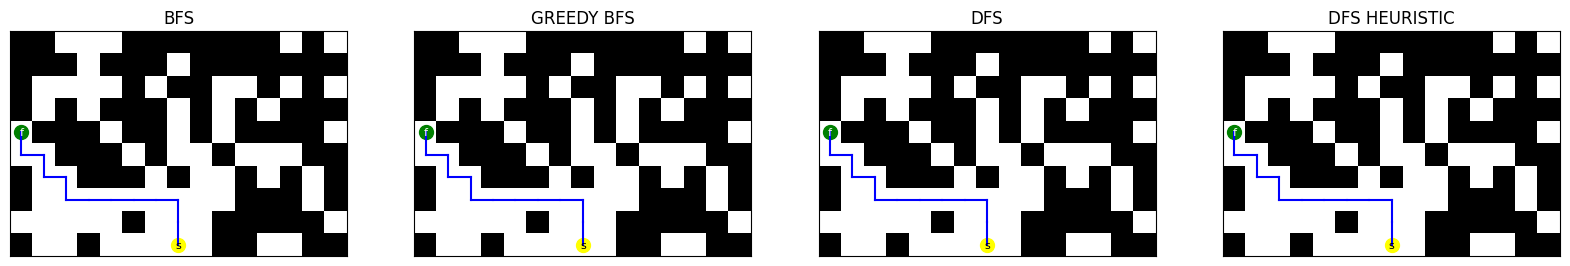

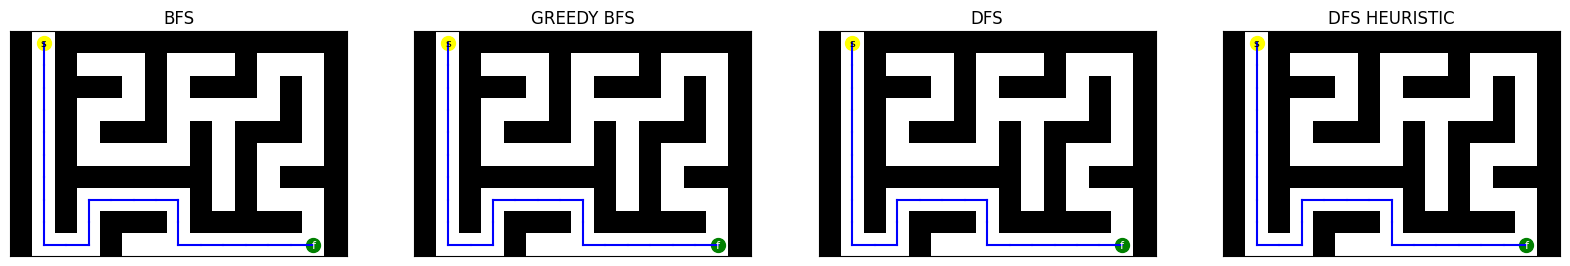

In [71]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    }
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [72]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [73]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                 iterations  \
                      bfs greedy_bfs       dfs  dfs_heur         bfs   
percent type                                                           
0.0     fixed_0  0.000236   0.000105  0.000060  0.000064  123.000000   
        fixed_1  0.000219   0.000112  0.000124  0.000088  111.000000   
        fixed_2  0.000221   0.000144  0.000056  0.000055  115.000000   
0.2     random   0.000104   0.000031  0.000082  0.000032   60.257000   
0.4     random   0.000074   0.000045  0.000065  0.000056   43.485000   
0.6     random   0.000045   0.000038  0.000033  0.000041   25.598000   
0.2     random   0.000170   0.000040  0.000089  0.000036  101.688000   
0.4     random   0.000128   0.000041  0.000079  0.000045   76.645000   
0.6     random   0.000098   0.000042  0.000056  0.000045   57.598000   
0.0     maze     0.000083   0.000073  0.000082  0.000069   49.221092   

                                                     length             \
                greedy_bfs         dfs   dfs_heur       bfs greedy_bfs   
percent type                                                             
0.0     fixed_0  36.000000   40.000000  22.000000  19.00000   19.00000   
        fixed_1  45.000000  102.000000  38.000000  17.00000   17.00000   
        fixed_2  59.000000   40.000000  22.000000  19.00000   27.00000   
0.2     random   12.136000   75.629000  17.087000   9.34700    9.82900   
0.4     random   21.361000   59.734000  32.622000  13.76200   14.13600   
0.6     random   19.564000   29.842000  23.838000  14.66400   14.75800   
0.2     random   14.351000   81.237000  18.727000  12.27900   12.79900   
0.4     random   16.480000   71.243000  24.719000  12.67700   13.36700   
0.6     random   17.620000   49.166000  24.700000  13.49400   14.00400   
0.0     maze     40.026815   73.258702  42.379967  36.86267   36.86267   

                                      
                       dfs  dfs_heur  
percent type                          
0.0     fixed_0   39.00000  21.00000  
        fixed_1  101.00000  37.00000  
        fixed_2   39.00000  21.00000  
0.2     random    41.83100  11.76500  
0.4     random    21.25400  16.14200  
0.6     random    16.17400  15.57400  
0.2     random    56.50300  15.36700  
0.4     random    35.38300  16.17300  
0.6     random    27.13000  16.41600  
0.0     maze      36.86267  36.86267

## Let's add another algorithm, but introduce costs.

A* algorithm is used here. The heuristic gave us some speed ups, but it isn't guaranteed to find the optimal path. We'll introduce costs here.

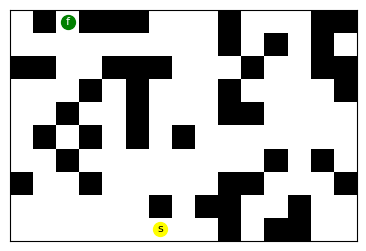

In [38]:
percent_blockage = 0.25

graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

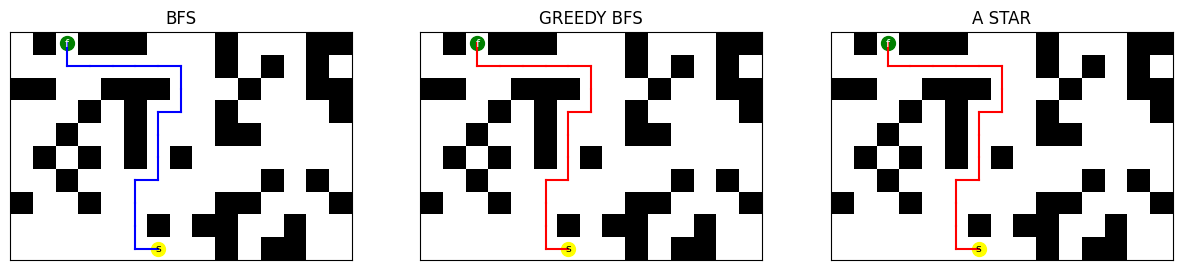

BFS:
Time: 0.00028634071350097656 (s)
# Iteractions: 98
Path length: 17

GREEDY BFS:
Time: 9.894371032714844e-05 (s)
# Iteractions: 27
Path length: 17

A STAR:
Time: 0.00016498565673828125 (s)
# Iteractions: 45
Path length: 17


In [39]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
astar_path, astar_complexity = graph.search(a_star)

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], astar_path, c='red',label='A STAR')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("A STAR:")
print("Time:", astar_complexity["time"], "(s)")
print("# Iteractions:", astar_complexity["iterations"])
print("Path length:", astar_complexity["length"])

### Let's see it in action

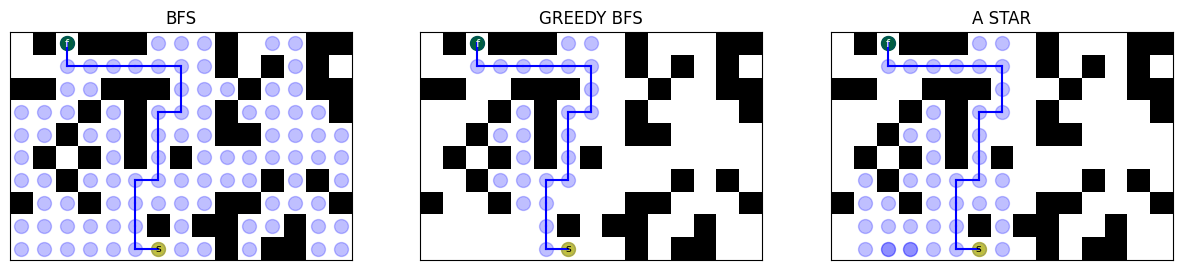

In [40]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

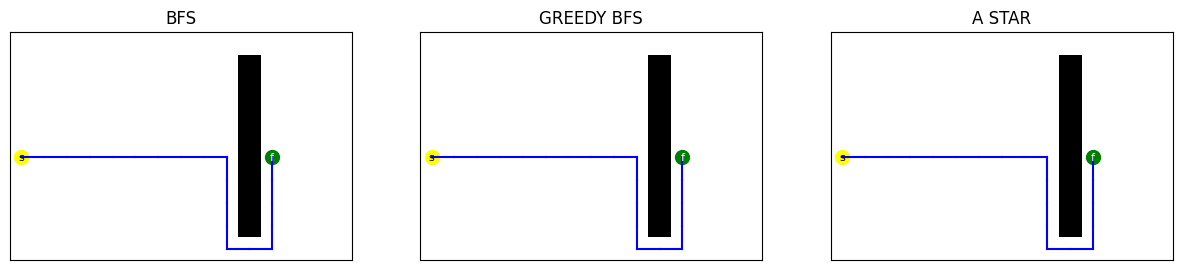

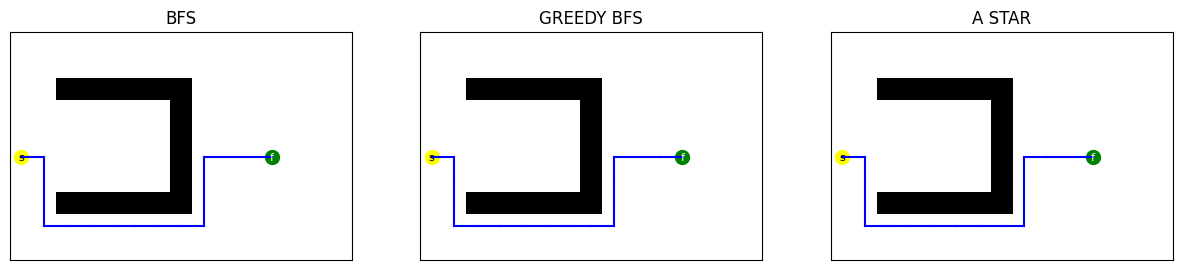

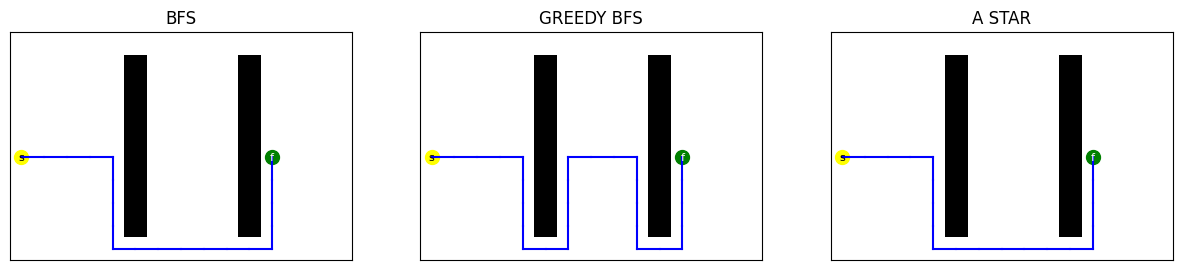

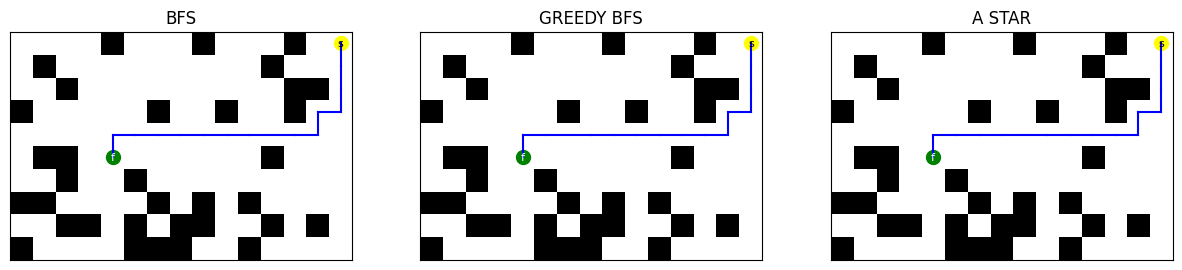

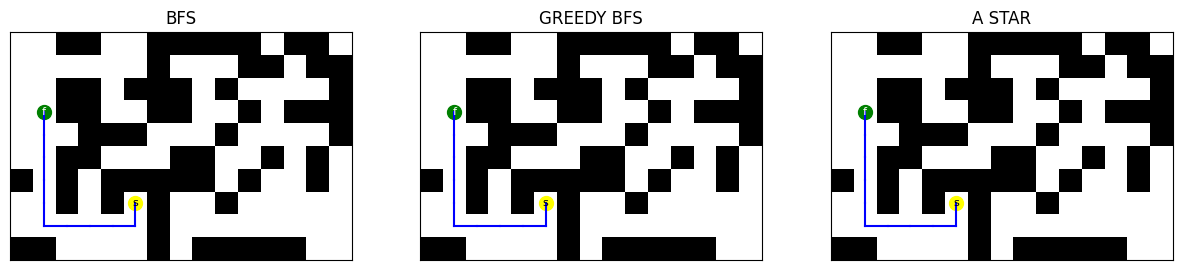

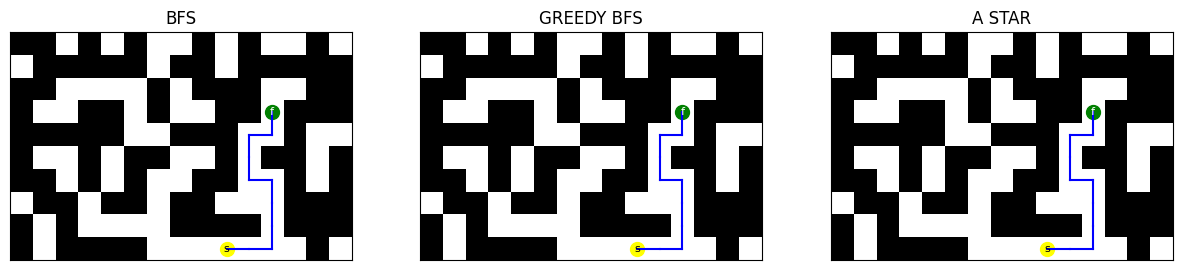

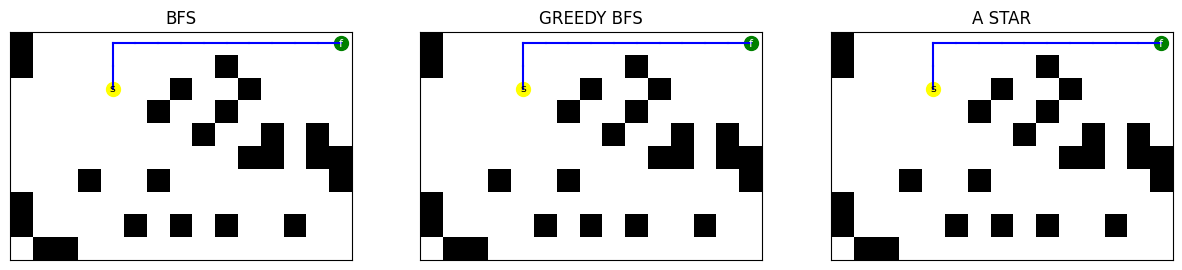

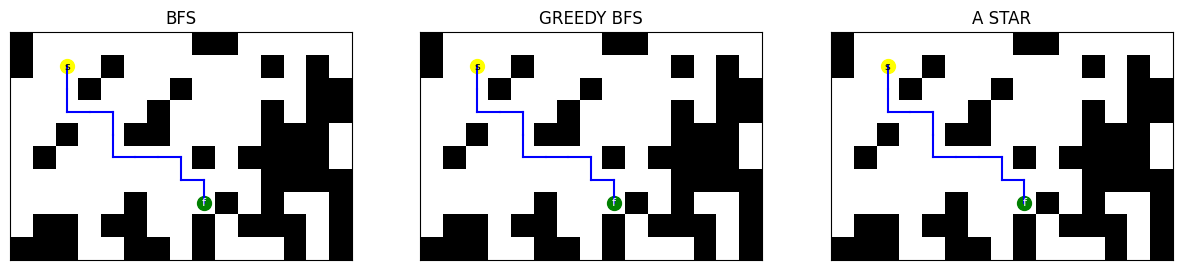

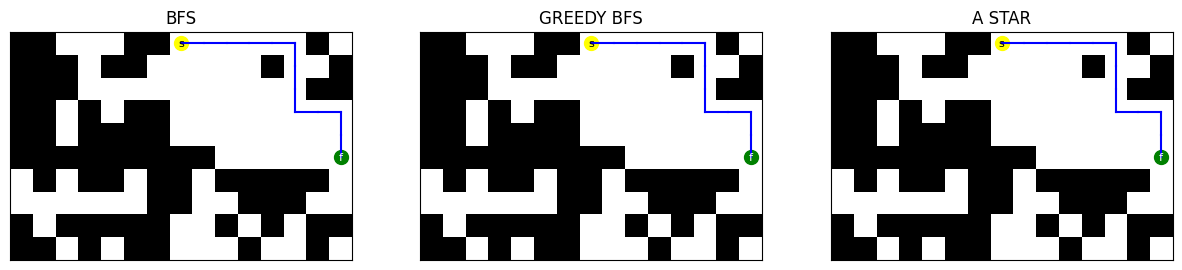

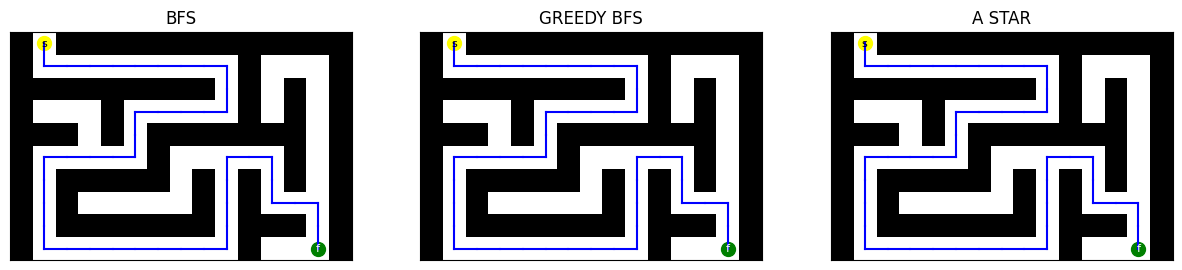

In [74]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

to_search = [
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    },
]

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
    }

    graph.generate_grid(grid_type="fixed", variant=variant)

    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for i, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        data[name] = {}

        data[name]["time"] = complexity["time"]
        data[name]["iterations"] = complexity["iterations"]
        data[name]["length"] = complexity["length"]

        plot_path(axes[i], path, c='blue',label=label)

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            if i == n - 1:
                _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

            for j, search in enumerate(to_search):
                fct = search["fct"]
                name = search["name"]
                label = search["label"]
                path, complexity = graph.search(search["fct"])

                if name not in data:
                    data[name] = {"time": 0, "iterations": 0, "length": 0}

                data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                if i == n - 1:
                    plot_path(axes[j], path, c='blue',label=label)
        plt.show()
        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    if i == n - 1:
        _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

    for j, search in enumerate(to_search):
        fct = search["fct"]
        name = search["name"]
        label = search["label"]
        path, complexity = graph.search(search["fct"])

        if complexity["time"] is None: break

        if name not in data:
            data[name] = {"time": 0, "iterations": 0, "length": 0}

        data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
        data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
        data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

        if i == n - 1:
            plot_path(axes[j], path, c='blue',label=label)
plt.show()
datas.append(data)


In [75]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [76]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                       iterations             \
                      bfs greedy_bfs    a_star         bfs greedy_bfs   
percent type                                                            
0.0     fixed_0  0.000257   0.000142  0.000233  123.000000  36.000000   
        fixed_1  0.000215   0.000117  0.000118  111.000000  45.000000   
        fixed_2  0.000222   0.000142  0.000181  115.000000  59.000000   
0.2     random   0.000109   0.000033  0.000045   63.883000  12.790000   
0.4     random   0.000073   0.000044  0.000052   42.983000  20.933000   
0.6     random   0.000043   0.000037  0.000039   24.720000  18.888000   
0.2     random   0.000169   0.000040  0.000062  101.795000  14.336000   
0.4     random   0.000130   0.000042  0.000057   76.957000  16.238000   
0.6     random   0.000095   0.000042  0.000055   55.466000  17.146000   
0.0     maze     0.000083   0.000074  0.000081   49.382402  40.087083   

                               length                        
                    a_star        bfs greedy_bfs     a_star  
percent type                                                 
0.0     fixed_0  96.000000  19.000000  19.000000  19.000000  
        fixed_1  47.000000  17.000000  17.000000  17.000000  
        fixed_2  72.000000  19.000000  27.000000  19.000000  
0.2     random   18.574000   9.711000  10.209000   9.711000  
0.4     random   25.058000  13.597000  13.909000  13.597000  
0.6     random   19.911000  14.251000  14.301000  14.251000  
0.2     random   24.884000  12.270000  12.804000  12.270000  
0.4     random   23.310000  12.722000  13.370000  12.722000  
0.6     random   23.363000  13.337000  13.843000  13.337000  
0.0     maze     43.165184  36.841758  36.841758  36.841758

# Exhaustive Search

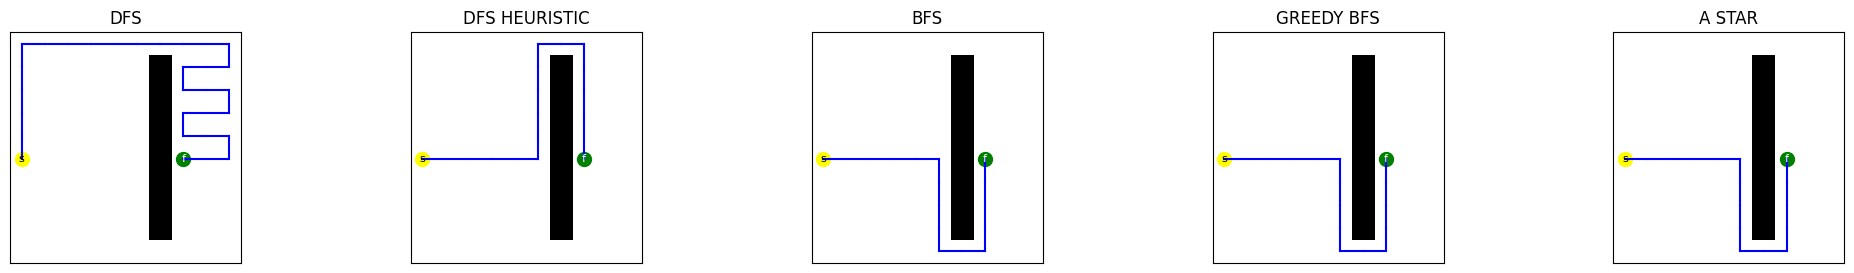

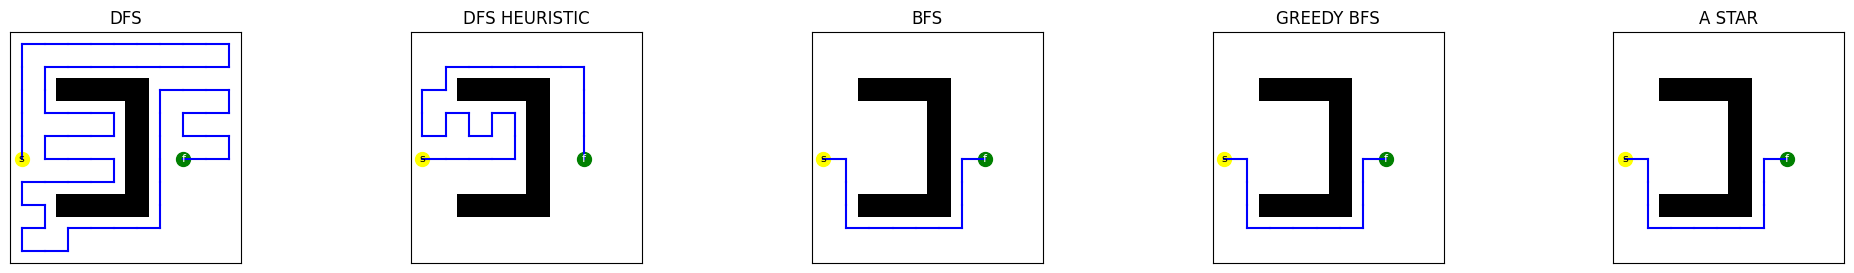

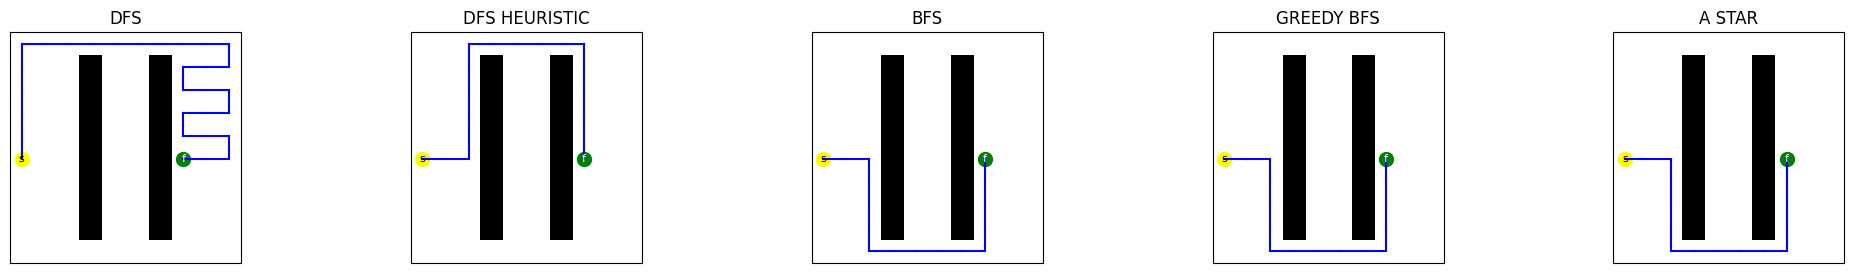

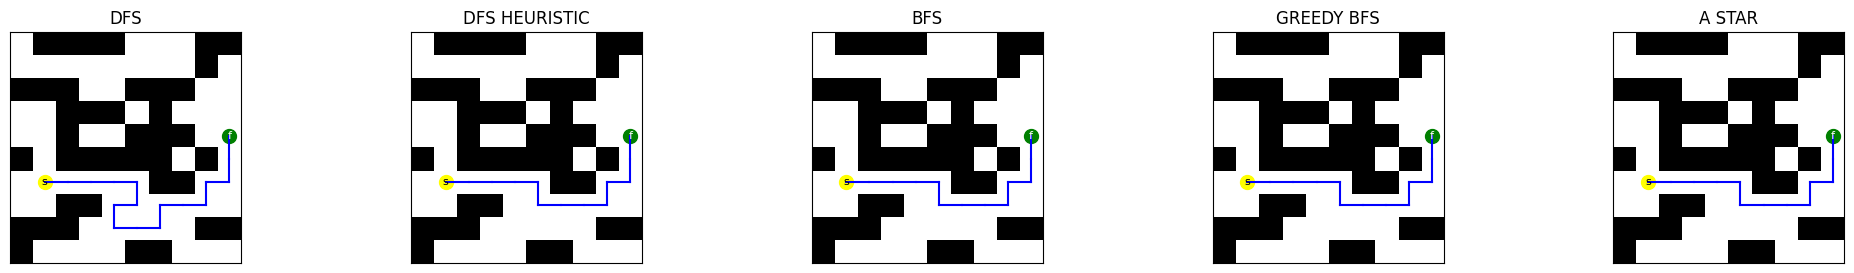

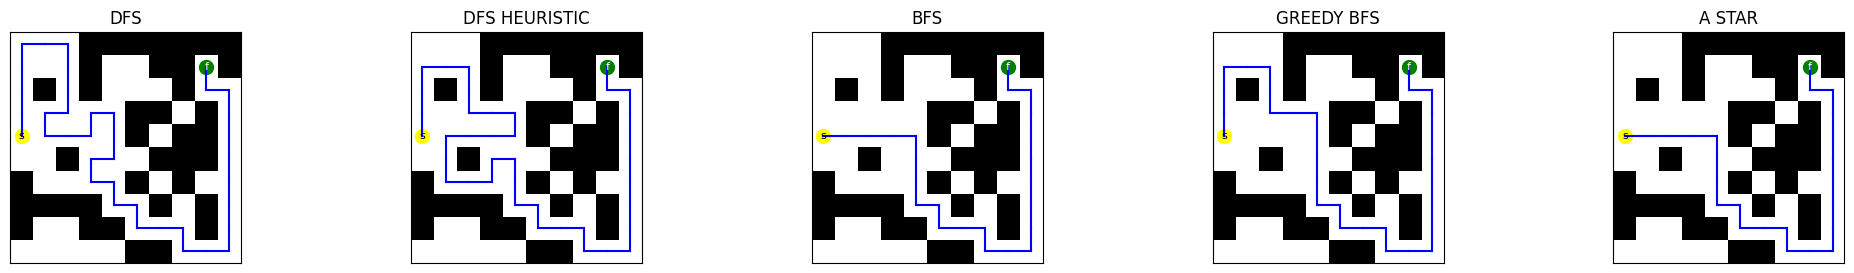

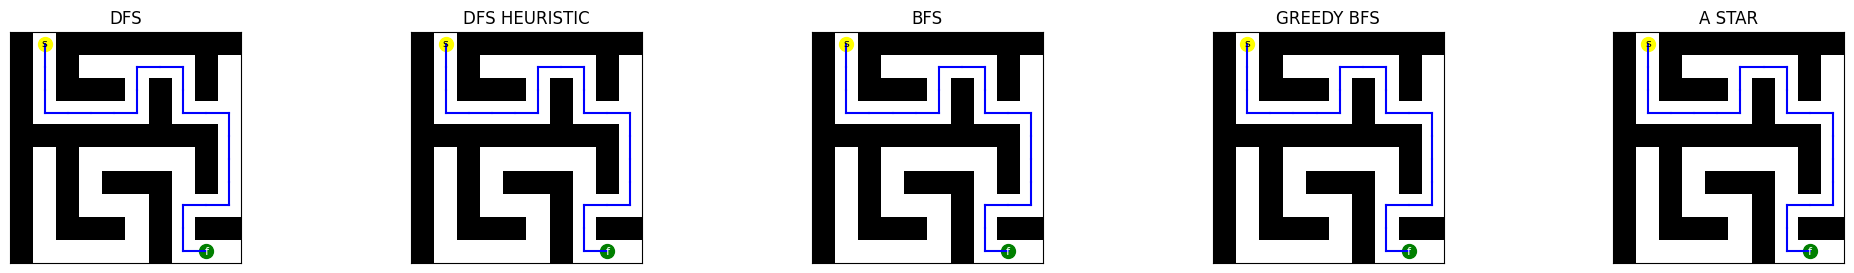

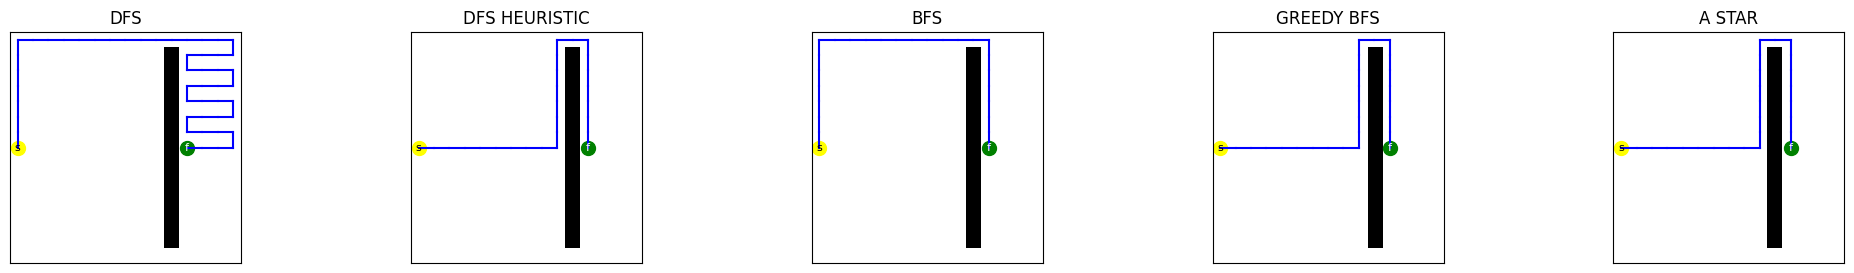

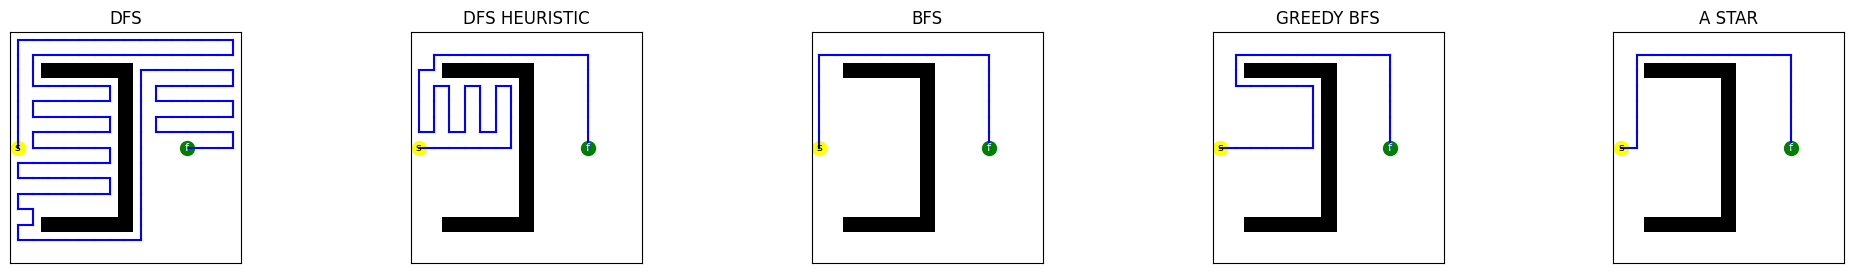

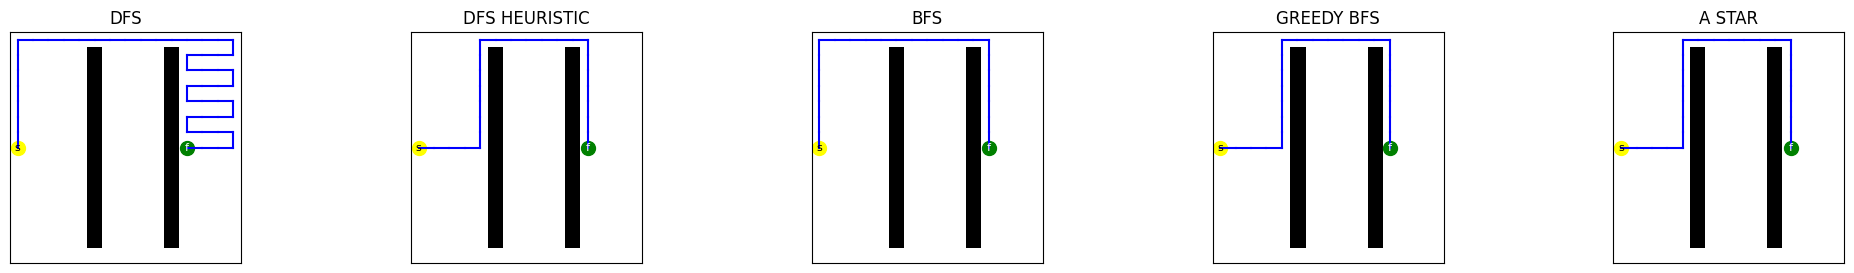

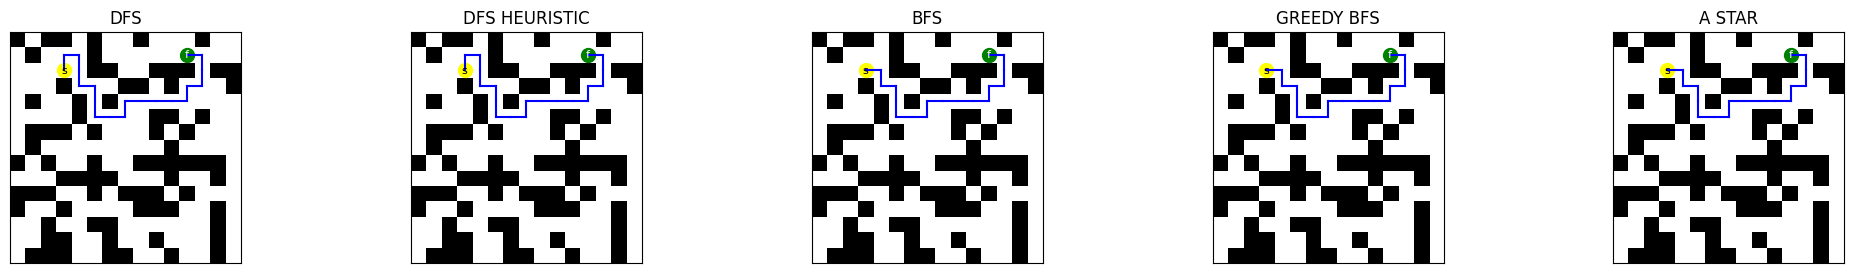

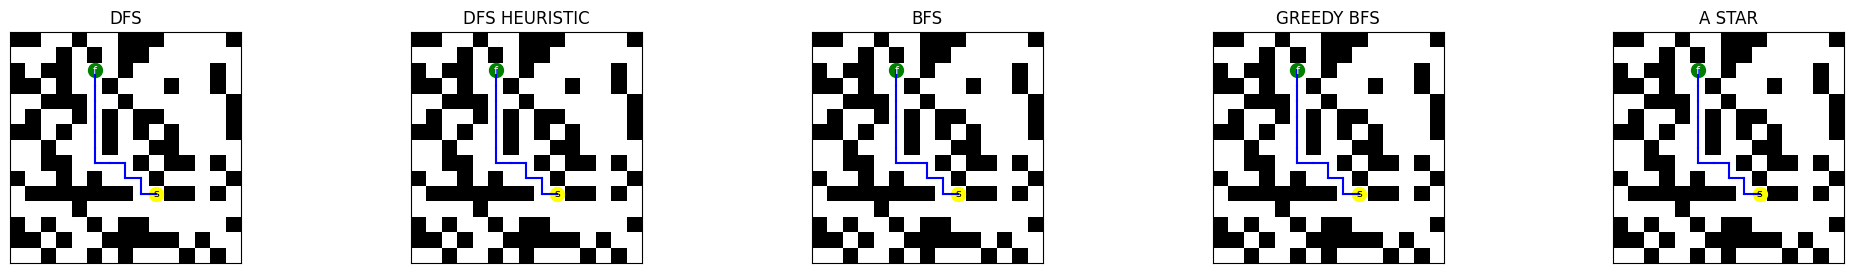

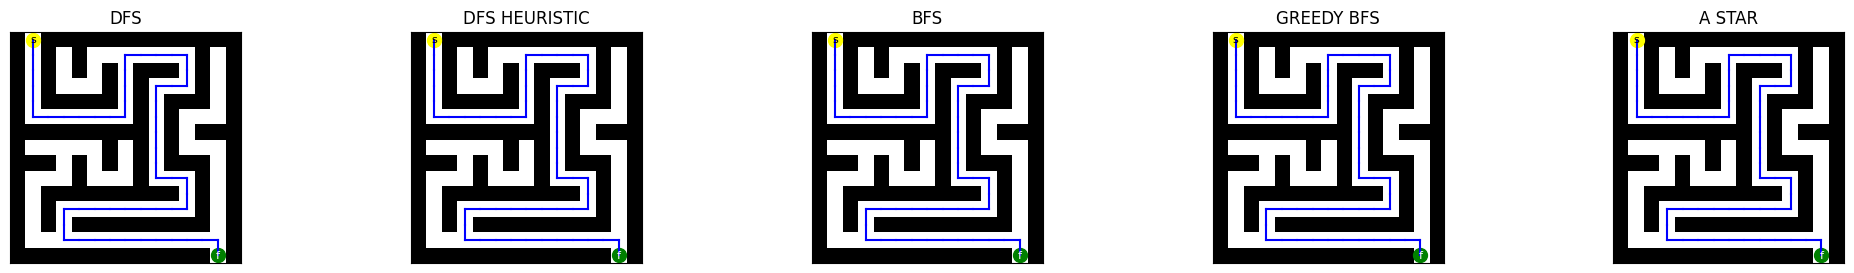

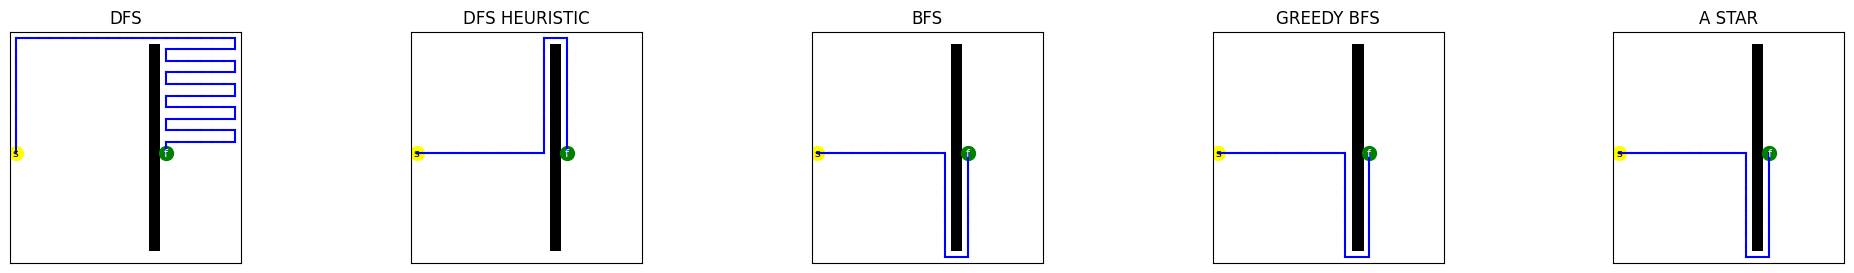

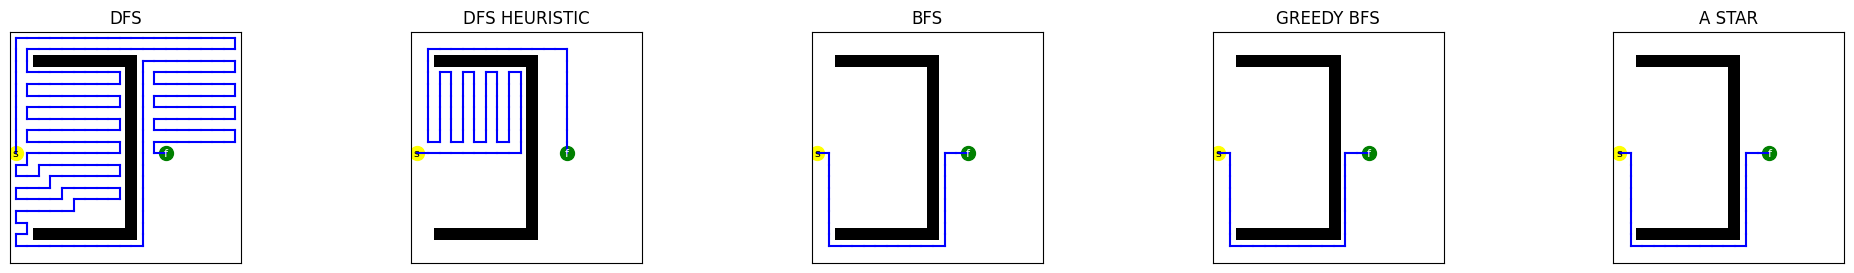

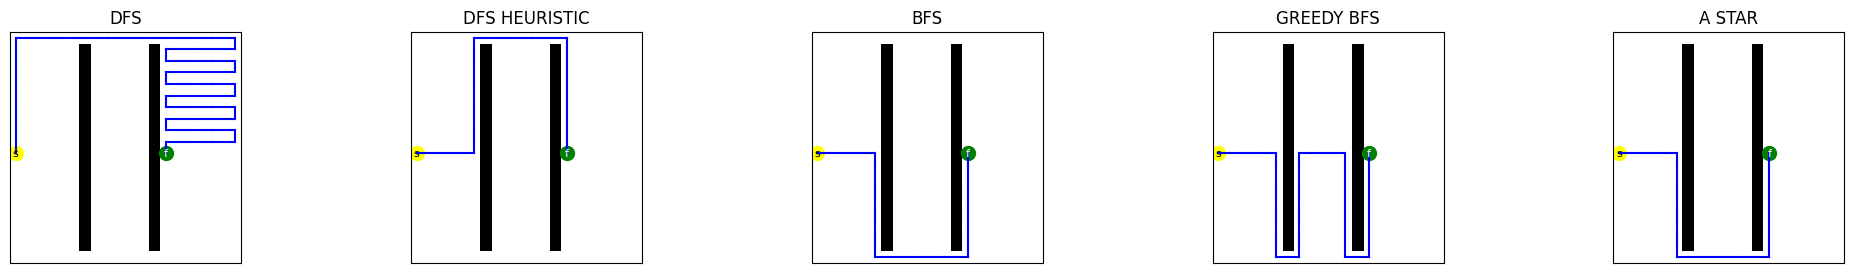

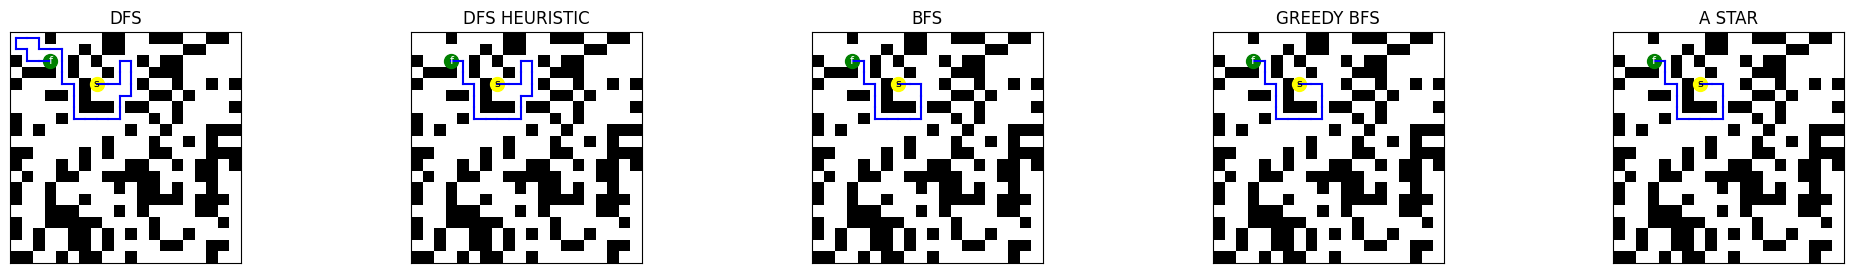

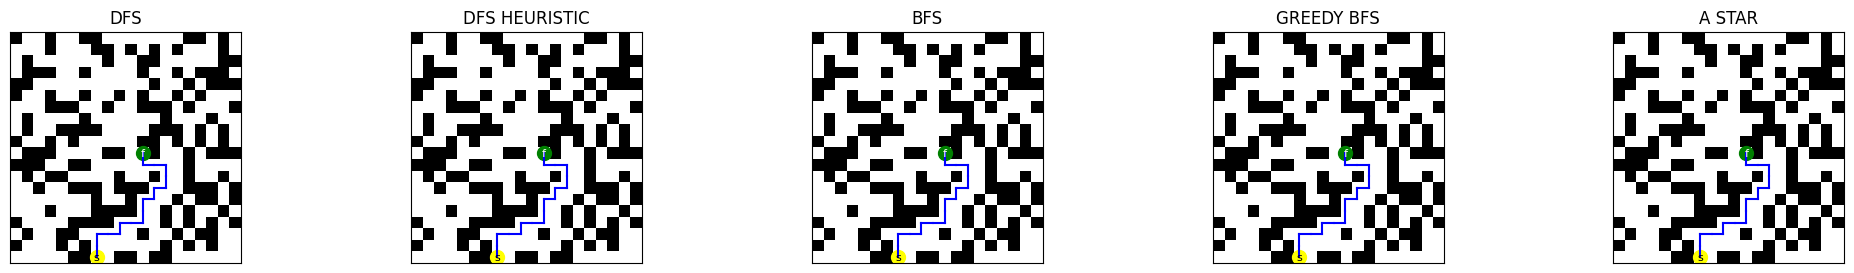

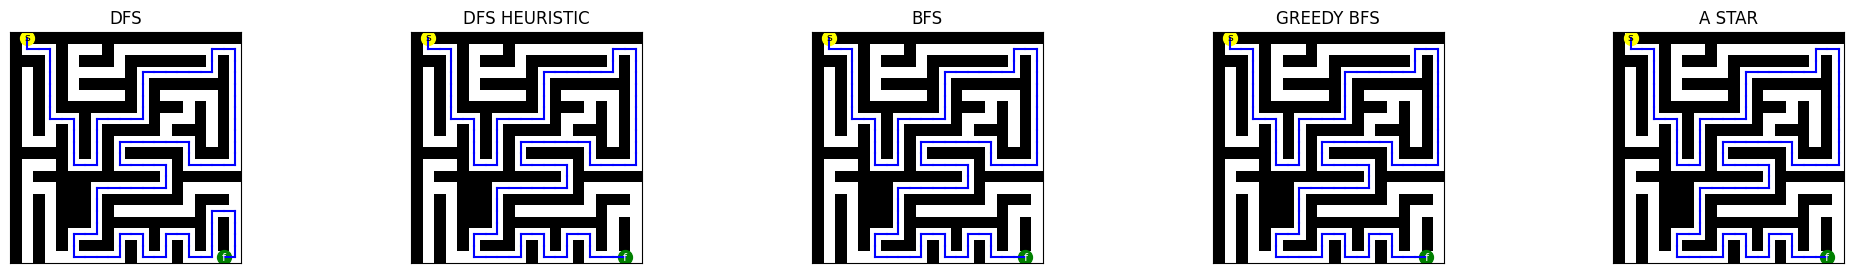

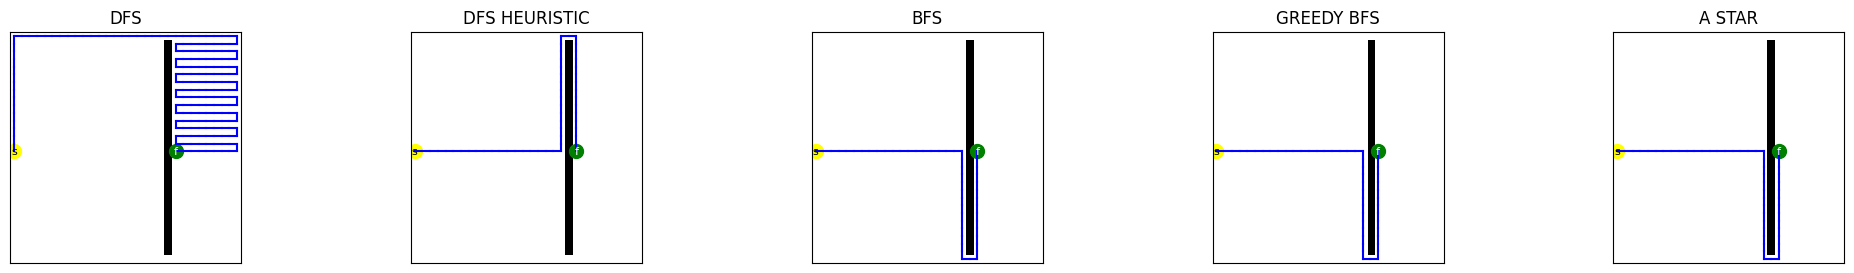

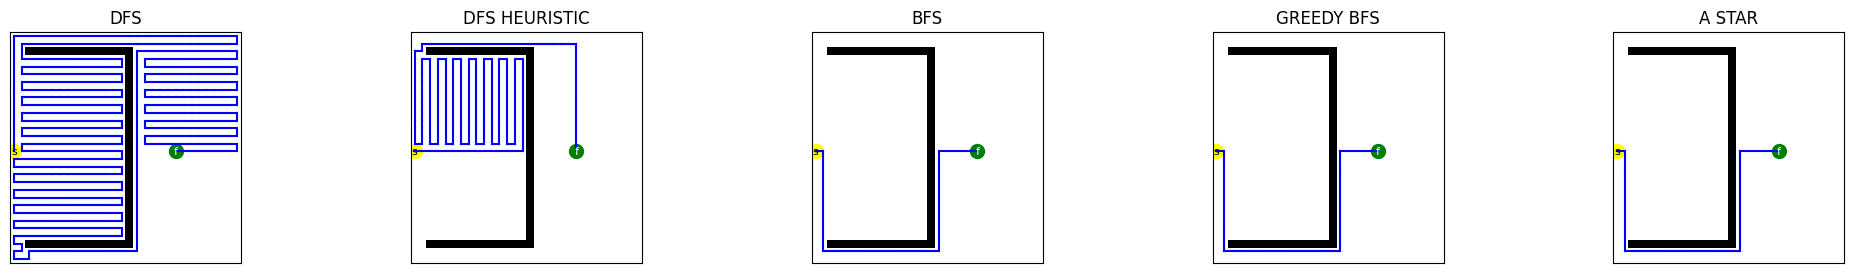

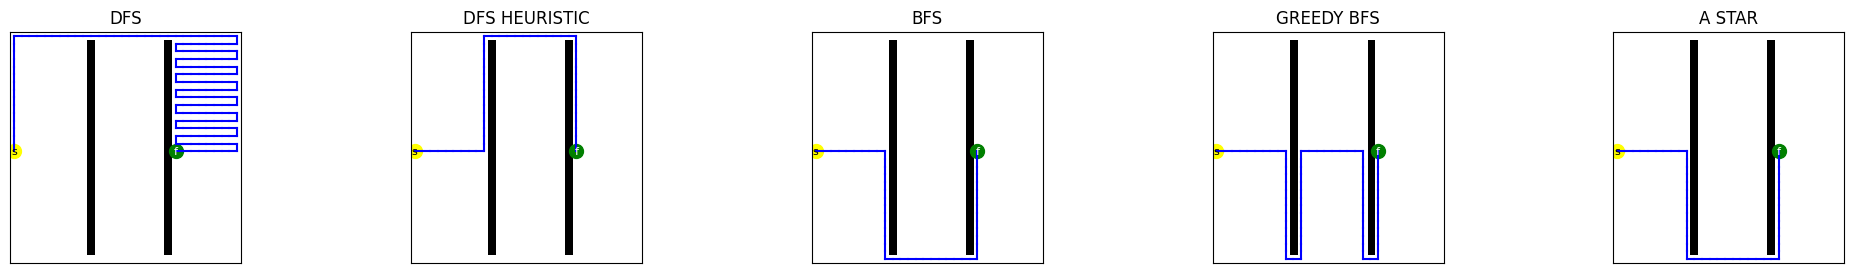

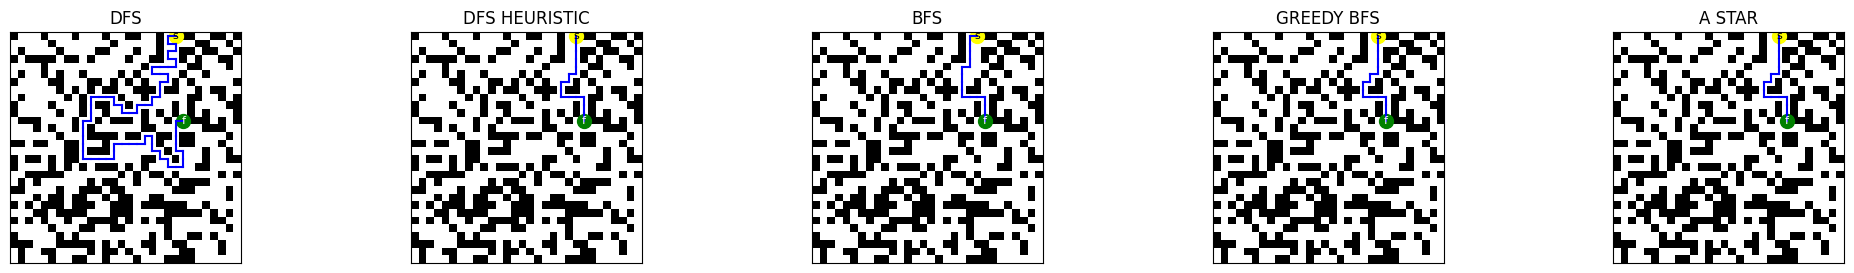

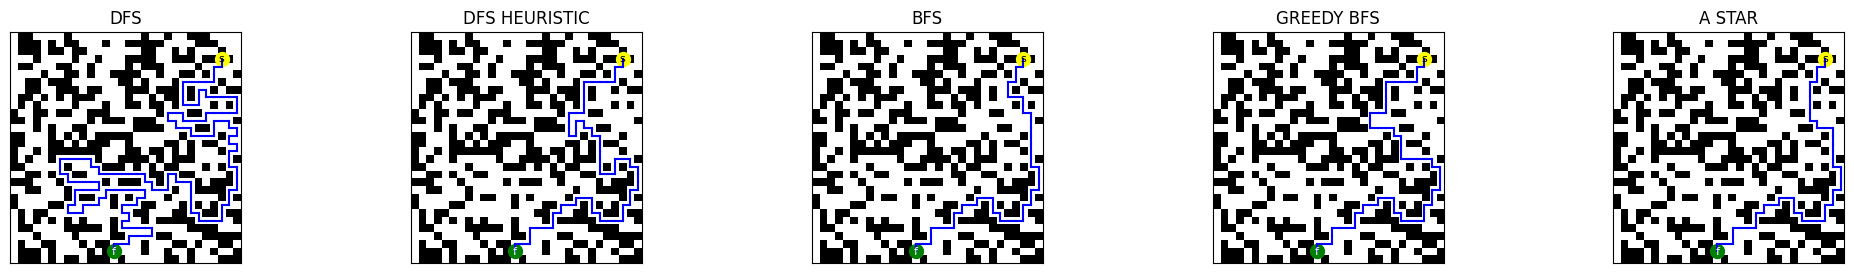

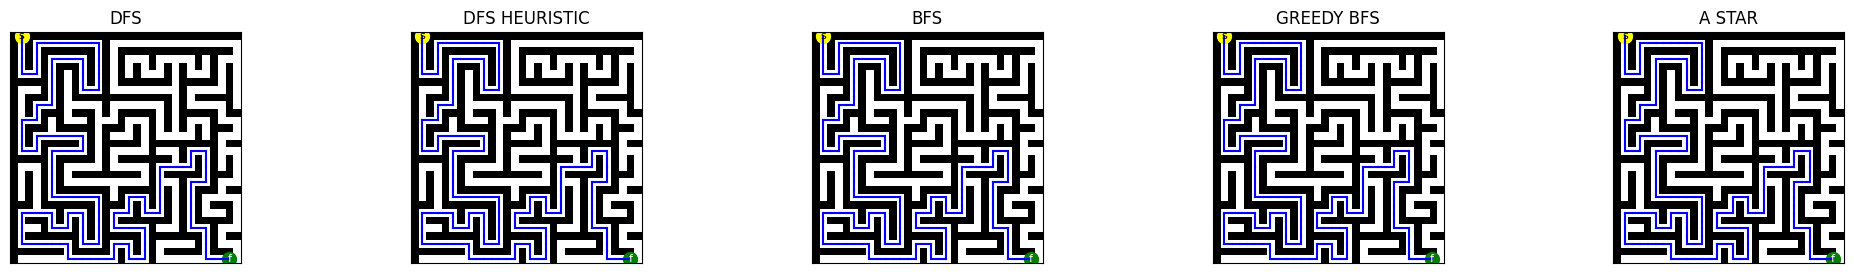

In [77]:
n = 500

datas = []

dimensions = [(10,10), (15,15), (20,20), (30,30)]
percent_blockages = [0.2, 0.4, 0.6]

to_search = [
    {
        "name": "dfs",
        "label": "DFS",
        "fct": dfs,
    },
    {
        "name": "dfs_heur",
        "label": "DFS HEURISTIC",
        "fct": dfs_heuristic,
    },
    {
        "name": "bfs",
        "label": "BFS",
        "fct": bfs,
    },
    {
        "name": "greedy_bfs",
        "label": "GREEDY BFS",
        "fct": greedy_bfs,
    },
    {
        "name": "a_star",
        "label": "A STAR",
        "fct": a_star,
    }
]

for (rows, cols) in dimensions:
    
    graph = Graph(rows=rows, cols=cols)

    for variant in [0,1,2]:
        data = {
            "percent": 0,
            "dimension": (rows, cols),
            "type": "fixed_" + str(variant),
        }
        graph.generate_grid(grid_type="fixed", variant=variant)

        _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

        for i, search in enumerate(to_search):
            fct = search["fct"]
            name = search["name"]
            label = search["label"]
            path, complexity = graph.search(search["fct"])

            data[name] = {}

            data[name]["time"] = complexity["time"]
            data[name]["iterations"] = complexity["iterations"]
            data[name]["length"] = complexity["length"]

            plot_path(axes[i], path, c='blue',label=label)

        plt.show()

        datas.append(data)

    # Random grids with varying percent blockages
    for grid_type in ["random", "random-1"]:
        for percent in percent_blockages:
            data = {
                "percent": percent,
                "dimension": (rows, cols),
                "type": "random",
            }
            for i in range(n):
                graph.generate_grid(grid_type="random", percent_blocked=percent)

                if i == n - 1 and percent == 0.4:
                    _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
                    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

                for j, search in enumerate(to_search):
                    fct = search["fct"]
                    name = search["name"]
                    label = search["label"]
                    path, complexity = graph.search(search["fct"])

                    if name not in data:
                        data[name] = {"time": 0, "iterations": 0, "length": 0}

                    data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
                    data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
                    data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

                    if i == n - 1 and percent == 0.4:
                        plot_path(axes[j], path, c='blue',label=label)

            if percent == 0.4:
                plt.show()
            datas.append(data)
    # Maze grids
    data = {
        "percent": 0,
        "dimension": (rows, cols),
        "type": "maze",
    }
    for i in range(n):
        graph.generate_grid(grid_type="maze")

        if i == n - 1:
            _, axes = plt.subplots(ncols=len(to_search), nrows=1, figsize=(len(to_search) * 5, 3))
            plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

        for j, search in enumerate(to_search):
            fct = search["fct"]
            name = search["name"]
            label = search["label"]
            path, complexity = graph.search(search["fct"])

            if complexity["time"] is None: break

            if name not in data:
                data[name] = {"time": 0, "iterations": 0, "length": 0}

            data[name]["time"] = (data[name]["time"] * i + complexity["time"]) / (i + 1)
            data[name]["iterations"] = (data[name]["iterations"] * i + complexity["iterations"]) / (i + 1)
            data[name]["length"] = (data[name]["length"] * i + complexity["length"]) / (i + 1)

            if i == n - 1:
                plot_path(axes[j], path, c='blue',label=label)
    
    plt.show()
    datas.append(data)




In [78]:
data_df = {"percent": [], "type": [], "dimension": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    data_df["dimension"].append(d["dimension"])
    for k in ["time", "iterations", "length"]:
        for value in to_search:
            t = value["name"]
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [79]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type', 'dimension'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                           \
                                dfs  dfs_heur       bfs greedy_bfs    a_star   
percent type    dimension                                                      
0.0     fixed_0 (10, 10)   0.000056  0.000058  0.000205   0.000091  0.000142   
        fixed_1 (10, 10)   0.000096  0.000071  0.000154   0.000087  0.000090   
        fixed_2 (10, 10)   0.000052  0.000049  0.000142   0.000140  0.000108   
0.2     random  (10, 10)   0.000055  0.000028  0.000074   0.000026  0.000033   
0.4     random  (10, 10)   0.000044  0.000039  0.000053   0.000034  0.000038   
0.6     random  (10, 10)   0.000027  0.000033  0.000038   0.000033  0.000034   
0.2     random  (10, 10)   0.000055  0.000026  0.000073   0.000025  0.000032   
0.4     random  (10, 10)   0.000040  0.000037  0.000053   0.000033  0.000037   
0.6     random  (10, 10)   0.000025  0.000031  0.000035   0.000030  0.000032   
0.0     maze    (10, 10)   0.000056  0.000048  0.000054   0.000049  0.000051   
        fixed_0 (15, 15)   0.000075  0.000068  0.000389   0.000158  0.000345   
        fixed_1 (15, 15)   0.000192  0.000127  0.000372   0.000538  0.000266   
        fixed_2 (15, 15)   0.000070  0.000063  0.000375   0.000175  0.000250   
0.2     random  (15, 15)   0.000118  0.000037  0.000149   0.000036  0.000051   
0.4     random  (15, 15)   0.000087  0.000074  0.000103   0.000057  0.000069   
0.6     random  (15, 15)   0.000041  0.000054  0.000059   0.000051  0.000054   
0.2     random  (15, 15)   0.000116  0.000040  0.000152   0.000037  0.000054   
0.4     random  (15, 15)   0.000091  0.000078  0.000109   0.000061  0.000074   
0.6     random  (15, 15)   0.000043  0.000056  0.000062   0.000052  0.000056   
0.0     maze    (15, 15)   0.000151  0.000091  0.000111   0.000095  0.000103   
        fixed_0 (20, 20)   0.000126  0.000093  0.000579   0.000262  0.000548   
        fixed_1 (20, 20)   0.000332  0.000240  0.000581   0.000355  0.000401   
        fixed_2 (20, 20)   0.000119  0.000079  0.000572   0.000365  0.000446   
0.2     random  (20, 20)   0.000216  0.000064  0.000264   0.000050  0.000080   
0.4     random  (20, 20)   0.000154  0.000139  0.000179   0.000095  0.000123   
0.6     random  (20, 20)   0.000057  0.000075  0.000082   0.000071  0.000075   
0.2     random  (20, 20)   0.000215  0.000064  0.000264   0.000048  0.000084   
0.4     random  (20, 20)   0.000147  0.000126  0.000164   0.000089  0.000113   
0.6     random  (20, 20)   0.000058  0.000077  0.000083   0.000071  0.000077   
0.0     maze    (20, 20)   0.000258  0.000178  0.000205   0.000172  0.000200   
        fixed_0 (30, 30)   0.000215  0.000122  0.001384   0.000529  0.001320   
        fixed_1 (30, 30)   0.001253  0.000502  0.001334   0.000795  0.001215   
        fixed_2 (30, 30)   0.000222  0.000123  0.001351   0.000875  0.001083   
0.2     random  (30, 30)   0.000467  0.000103  0.000572   0.000071  0.000144   
0.4     random  (30, 30)   0.000346  0.000284  0.000350   0.000169  0.000253   
0.6     random  (30, 30)   0.000092  0.000126  0.000134   0.000118  0.000129   
0.2     random  (30, 30)   0.000475  0.000103  0.000600   0.000075  0.000158   
0.4     random  (30, 30)   0.000352  0.000316  0.000383   0.000183  0.000268   
0.6     random  (30, 30)   0.000095  0.000129  0.000138   0.000122  0.000133   
0.0     maze    (30, 30)   0.000598  0.000372  0.000435   0.000347  0.000439   

                           iterations                                      \
                                  dfs    dfs_heur         bfs  greedy_bfs   
percent type    dimension                                                   
0.0     fixed_0 (10, 10)    30.000000   18.000000   81.000000   32.000000   
        fixed_1 (10, 10)    72.000000   28.000000   75.000000   33.000000   
        fixed_2 (10, 10)    30.000000   18.000000   73.000000   45.000000   
0.2     random  (10, 10)    50.626000   14.338000   41.042000   10.032000   
0.4     random  (10, 10)    40.232000   21.884000  

## Let's see these in action on the fixed grid variants

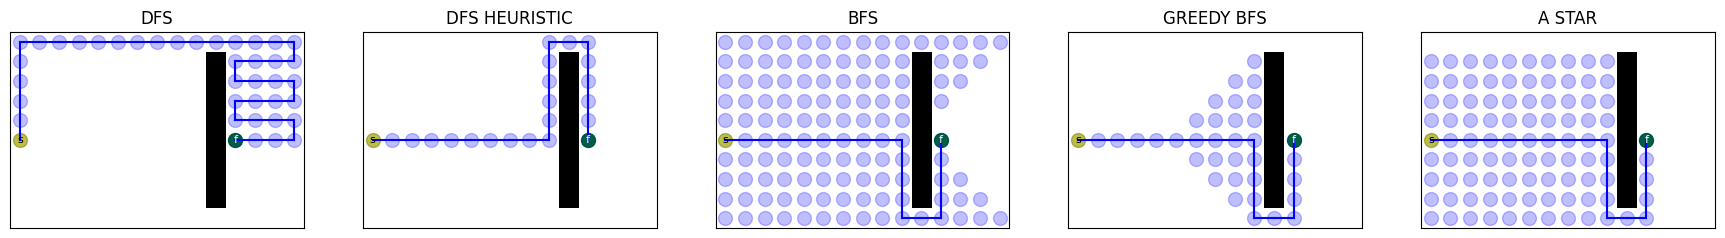

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
dfs
a_star
bfs


In [80]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=0)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

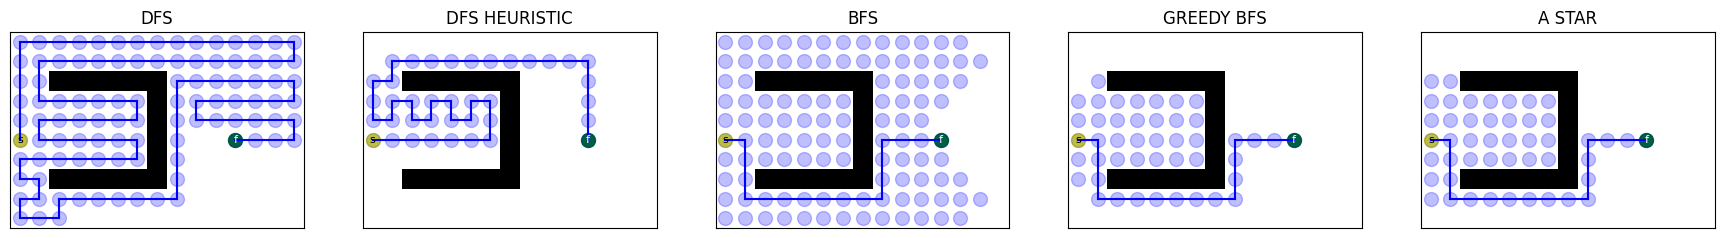

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [81]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=1)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

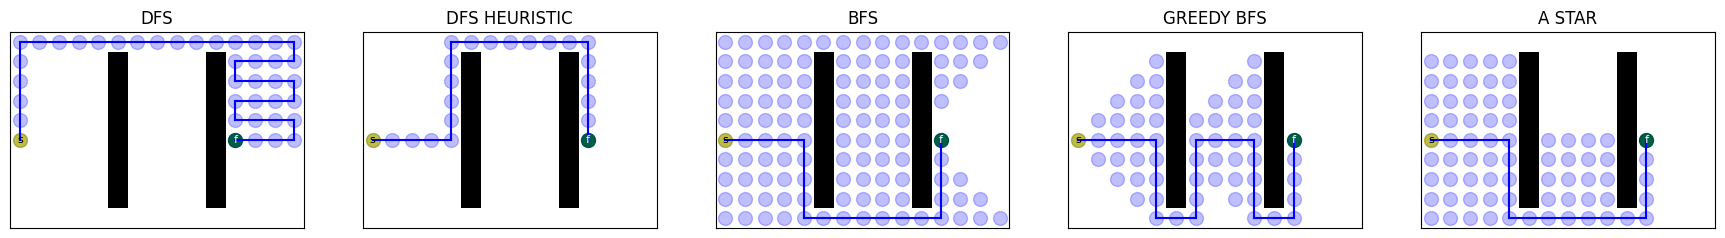

ORDER (fast to slow):
dfs_heuristic
dfs
greedy_bfs
a_star
bfs


In [82]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=2)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

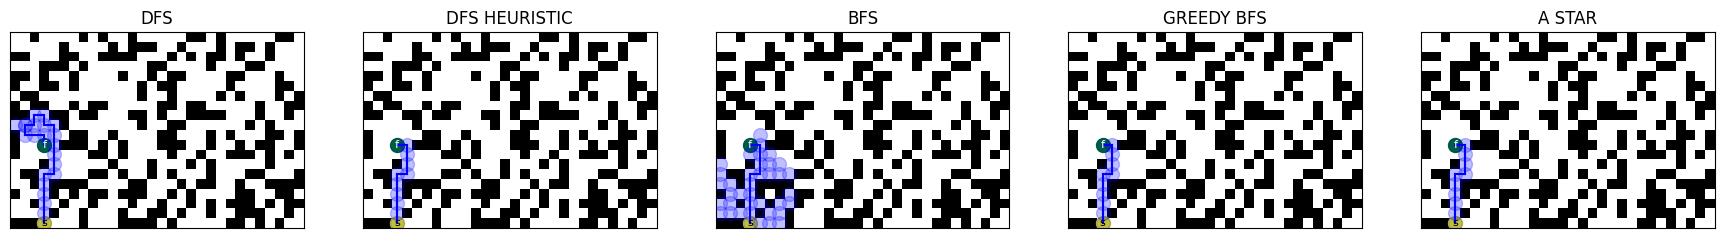

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [83]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

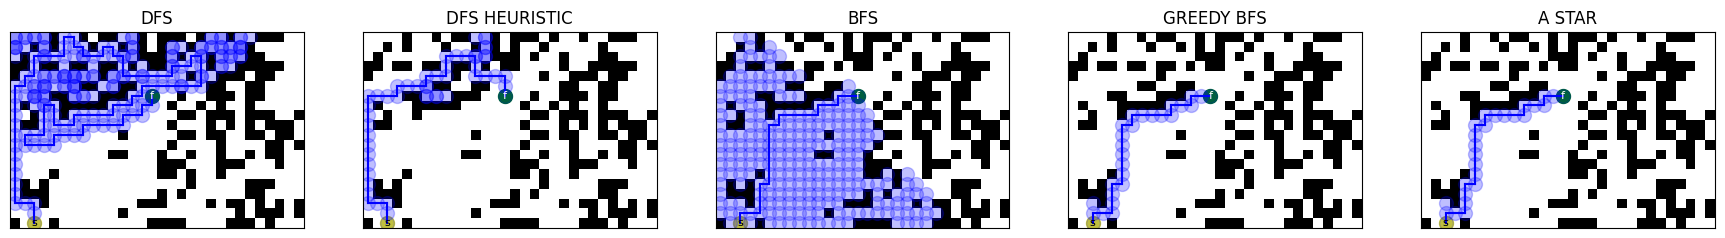

ORDER (fast to slow):
greedy_bfs
a_star
dfs_heuristic
dfs
bfs


In [84]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random-1", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

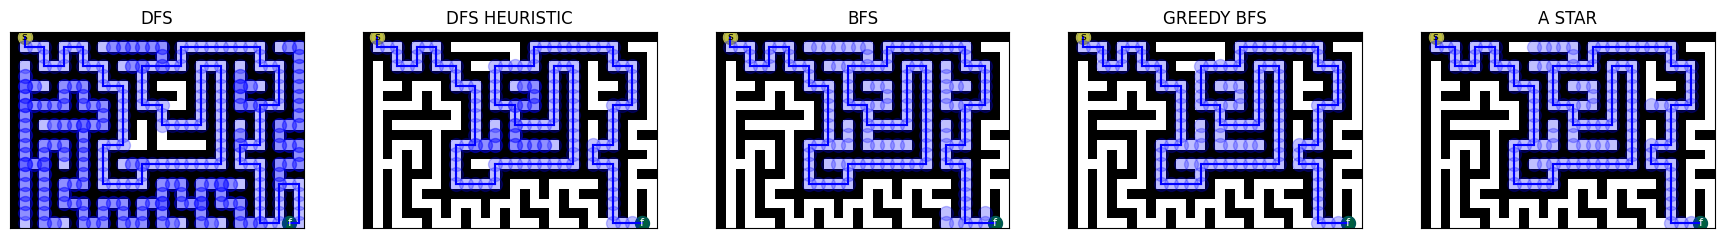

ORDER (fast to slow):
greedy_bfs
a_star
dfs_heuristic
bfs
dfs


In [85]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="maze")

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()